In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import scipy
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import celeri

plt.rcParams["text.usetex"] = False

In [3]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# NOTE: This modification of the number of eigenvalues is for experiments
meshes[0].n_eigen = 100

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-06-27 13:02:27.978 | INFO     | celeri.celeri:get_logger:129 - Read: ../data/command/western_north_america_command.json
2024-06-27 13:02:27.979 | INFO     | celeri.celeri:get_logger:130 - RUN_NAME: 2024-06-27-13-02-27
2024-06-27 13:02:27.980 | INFO     | celeri.celeri:get_logger:131 - Write log file: ../runs/2024-06-27-13-02-27/2024-06-27-13-02-27.log
2024-06-27 13:02:27.980 | INFO     | celeri.celeri:read_data:136 - Reading data files
2024-06-27 13:02:27.985 | SUCCESS  | celeri.celeri:read_data:140 - Read: ../data/segment/western_north_america_segment.csv
2024-06-27 13:02:27.987 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/block/western_north_america_block.csv
2024-06-27 13:02:27.988 | SUCCESS  | celeri.celeri:read_data:152 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2024-06-27 13:02:28.013 | SUCCESS  | celeri.celeri:read_data:299 - Read: ../data/mesh/cascadia.msh
2024-06-27 13:02:28.017 | SUCCESS  | celeri.celeri:read_data:335 - Read: ../data/station/western_north_america_station.csv
2024-06-27 13:02:28.018 | INFO     | celeri.celeri:read_data:350 - No mogi_file_name
2024-06-27 13:02:28.019 | INFO     | celeri.celeri:read_data:372 - No sar_file_name


In [4]:
# command.reuse_elastic = 0

# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-06-27 13:02:28.753 | INFO     | celeri.celeri:get_elastic_operators:1608 - Using precomputed elastic operators


In [5]:
n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-06-27 13:02:29.353 | INFO     | celeri.celeri:get_slip_rate_constraints:1190 - Found 1 slip rate constraints
2024-06-27 13:02:29.356 | INFO     | celeri.celeri:get_slip_rate_constraints:1193 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


In [6]:
# From: https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0  # initial time
    tf = time.time()  # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf - ti  # returns the time difference


TicToc = TicTocGenerator()  # create an instance of the TicTocGen generator


# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print("Elapsed time: %f seconds.\n" % tempTimeInterval)


def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

# 1. Full direct dense block model solve


In [7]:
index = celeri.get_index(assembly, station, block, meshes)
estimation = addict.Dict()
estimation.data_vector = celeri.get_data_vector(assembly, index, meshes)
estimation.weighting_vector = celeri.get_weighting_vector(
    command, station, meshes, index
)
estimation.operator = celeri.get_full_dense_operator(operators, meshes, index)

# Solve the overdetermined linear system using only a weighting vector rather than matrix
tic()
estimation.state_covariance_matrix = np.linalg.inv(
    estimation.operator.T * estimation.weighting_vector @ estimation.operator
)
estimation.state_vector = (
    estimation.state_covariance_matrix
    @ estimation.operator.T
    * estimation.weighting_vector
    @ estimation.data_vector
)
toc()

celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

Elapsed time: 1.866131 seconds.



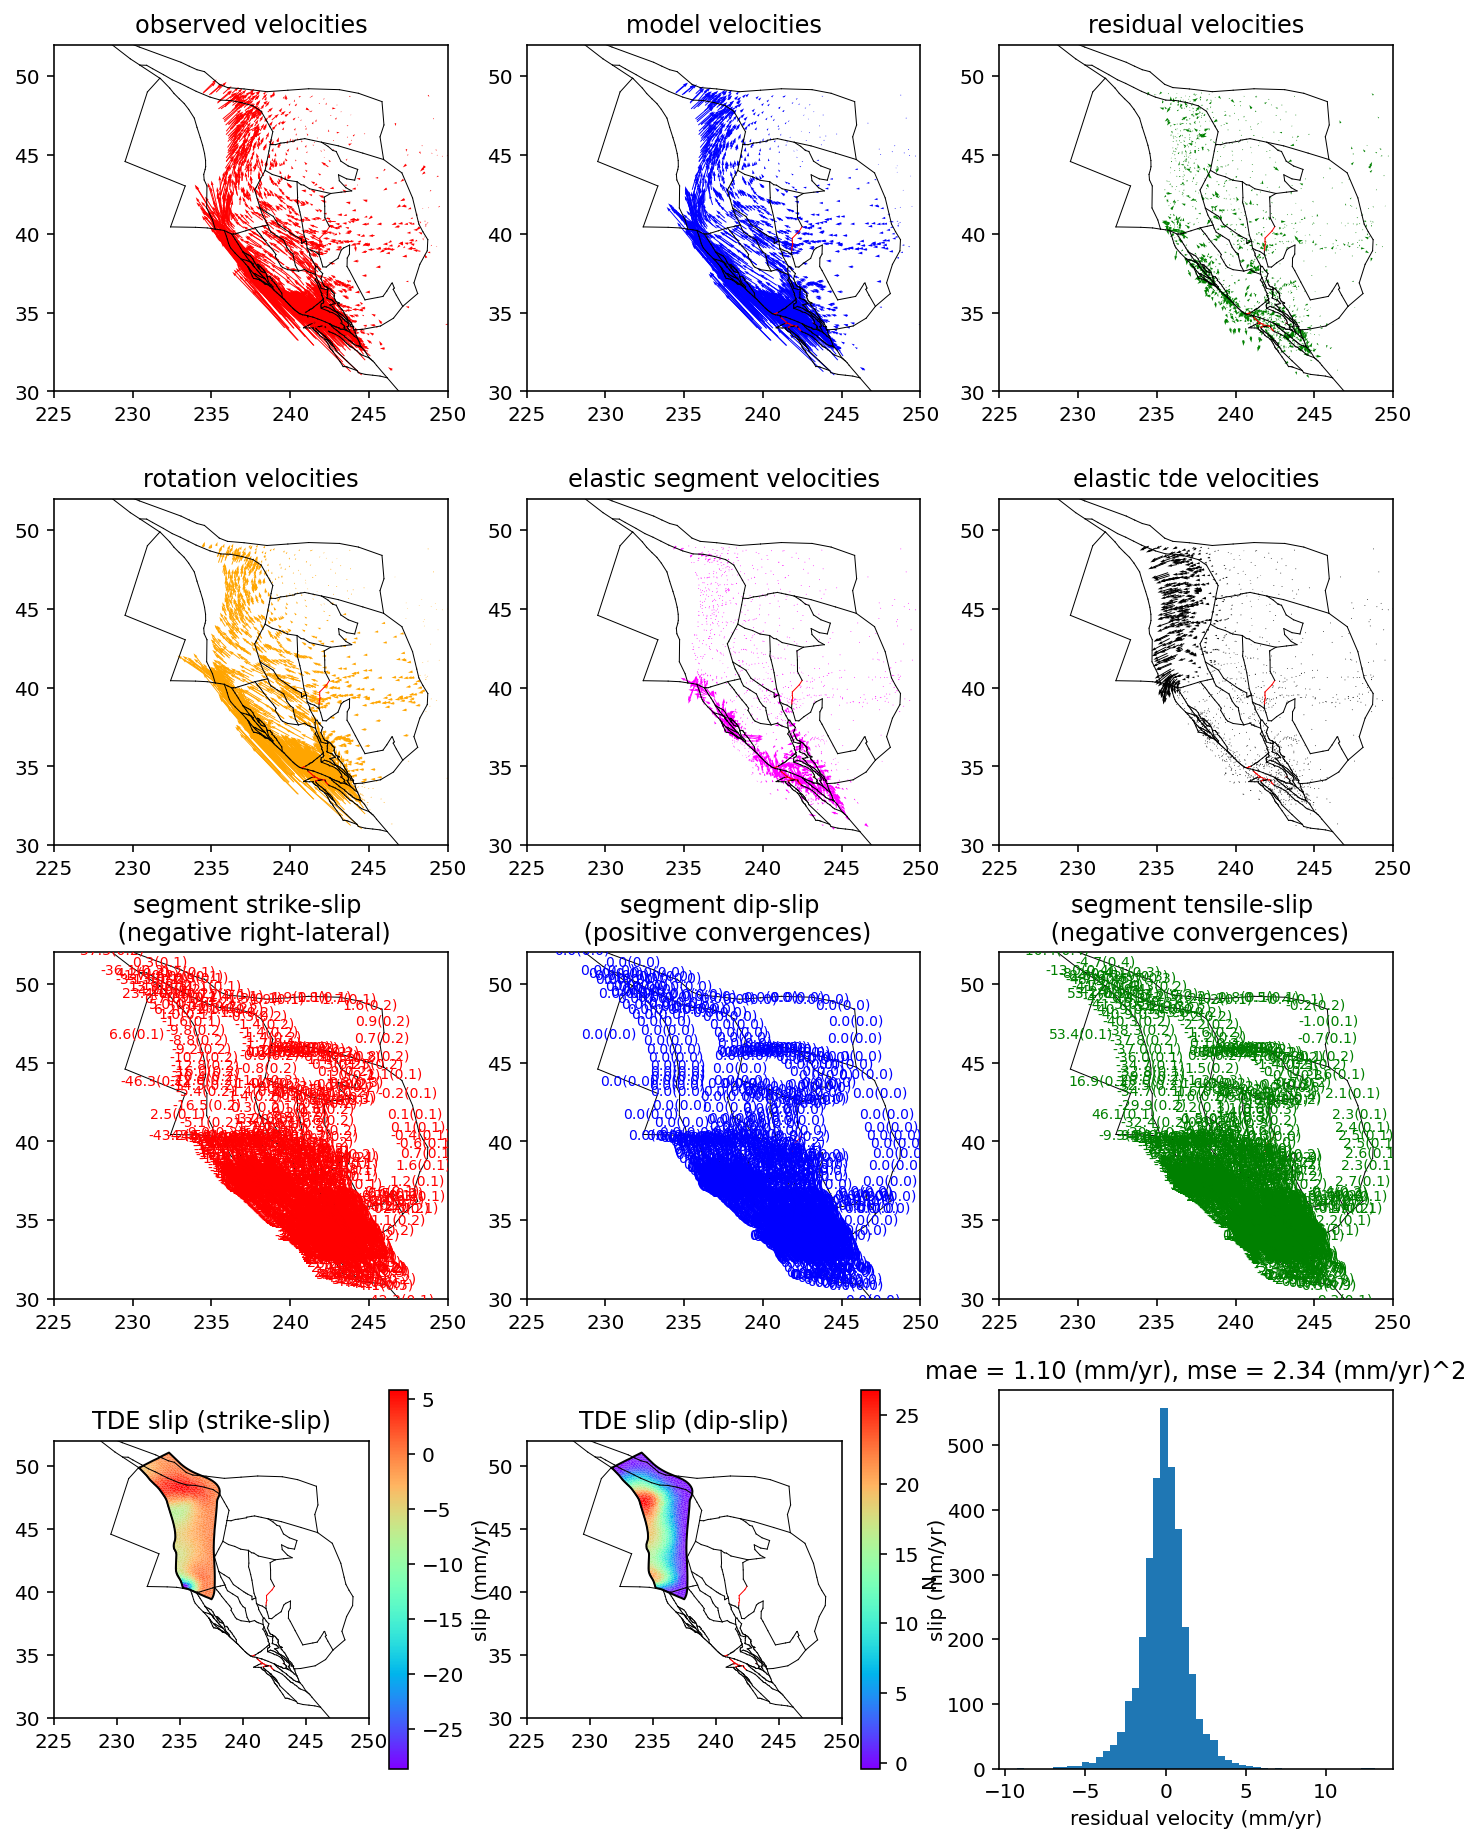

2024-06-27 13:02:38.520 | SUCCESS  | celeri.celeri:plot_estimation_summary:4996 - Wrote figures../runs/2024-06-27-13-02-27/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [8]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# 2. Unbounded and bounded QP solves with TDEs

In [9]:
lower_bound = -np.ones_like(estimation.state_vector)
upper_bound = np.ones_like(estimation.state_vector)

# TDE strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# TDE dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

lower_bound_tde_only = lower_bound[3 * n_blocks : :]
upper_bound_tde_only = upper_bound[3 * n_blocks : :]

# Options dictionary for lsqlin_qp
opts = {"show_progress": True}

# Unbounded
tic()
ret = celeri.lsqlin_qp(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    0,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    opts,
)
toc()

estimation_cvxopt_unbounded = copy.deepcopy(estimation)
estimation_cvxopt_unbounded.state_vector = np.array(ret["x"]).flatten()
celeri.post_process_estimation(estimation_cvxopt_unbounded, operators, station, index)

# Bounded TDE
tic()
ret = celeri.lsqlin_qp(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    0,
    None,
    None,
    None,
    None,
    lower_bound,
    upper_bound,
    None,
    opts,
)
toc()

estimation_cvxopt_bounded = copy.deepcopy(estimation)
estimation_cvxopt_bounded.state_vector = np.array(ret["x"]).flatten()
celeri.post_process_estimation(estimation_cvxopt_bounded, operators, station, index)

Elapsed time: 0.916496 seconds.

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  2e+06  2e-01  1e-23
 1: -3.4866e+14 -3.4866e+14  2e+05  1e-02  2e-23
 2: -3.4866e+14 -3.4866e+14  2e+04  1e-03  7e-24
 3: -3.4866e+14 -3.4866e+14  5e+03  1e-04  4e-24
 4: -3.4866e+14 -3.4866e+14  1e+03  2e-05  6e-24
 5: -3.4866e+14 -3.4866e+14  3e+02  5e-06  3e-24
 6: -3.4866e+14 -3.4866e+14  1e+02  1e-16  3e-24
Optimal solution found.
Elapsed time: 4.660565 seconds.



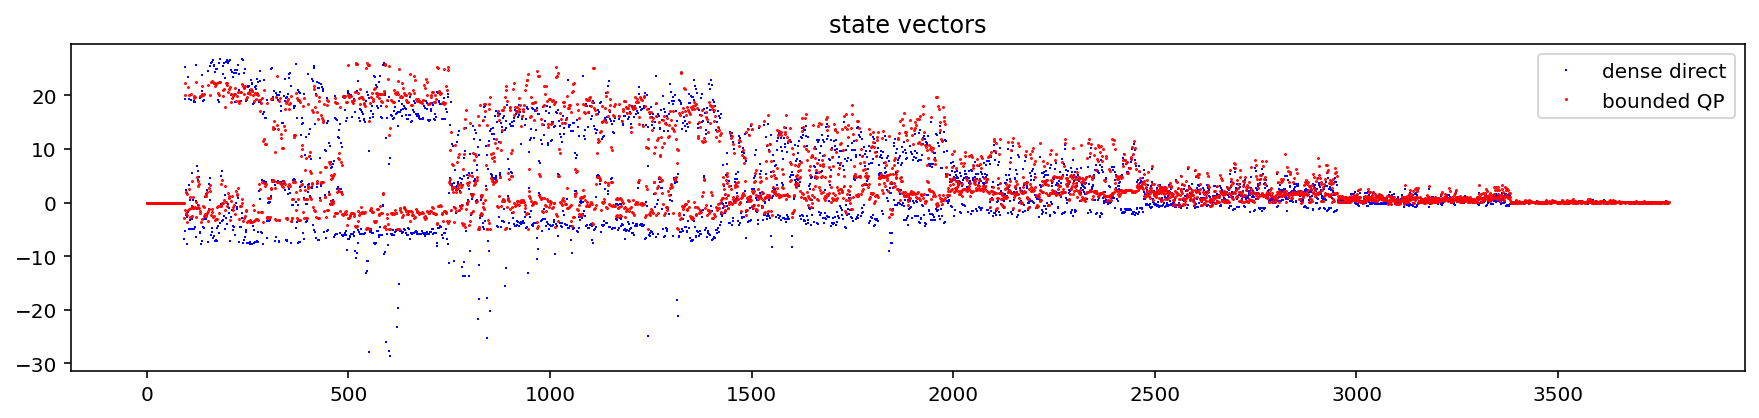

In [10]:
MARKERSIZE = 1
plt.figure(figsize=(15, 3))
plt.title("state vectors")
plt.plot(estimation.state_vector, "b+", label="dense direct", markersize=MARKERSIZE)
plt.plot(
    estimation_cvxopt_bounded.state_vector,
    "r.",
    label="bounded QP",
    markersize=MARKERSIZE,
)
plt.legend()
ret_bounded = ret

## KL machinery

In [11]:
def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


# Calculate eigenvales and eigenvectors for triangle subset
eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
    meshes[0].n_eigen,
    meshes[0].x_centroid,
    meshes[0].y_centroid,
    meshes[0].z_centroid,
)

# Create modified eigenvector matrix here
# This is a replication of the EVs for both slip components
# There are other ways to do this but as implemented is a sort of
# checkerboard like pattern.  The column indexing an every other
# row striding implements this.
eigenvectors_two_component = np.zeros(
    (2 * eigenvectors.shape[0], 2 * eigenvectors.shape[1])
)
for i in range(meshes[0].n_eigen):
    index_column_1 = 2 * i
    index_column_2 = 2 * i + 1
    eigenvectors_two_component[0::2, index_column_1] = eigenvectors[:, i]
    eigenvectors_two_component[1::2, index_column_2] = eigenvectors[:, i]
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6  # TODO: What should this conversion be?


def get_data_vector_eigen(assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_smoothing_row[i] : index.start_tde_smoothing_row[i]
            + index.n_tde_constraints[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator

    n_eigen = eigenvectors_two_component.shape[1] / 2
    print(f"{n_eigen=}")

    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            # + 2 * index.n_tde_total
            + index.n_tde_constraints_total,
            3 * index.n_blocks + 2 * int(n_eigen),
        )
    )
    print(f"{eigenvectors_two_component.shape=}")
    print(f"{operator.shape=}")

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # Insert eigenvector to velocity matrix
    tde_keep_row_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[0]
    )
    tde_keep_col_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[1]
    )
    eigen_to_velocities = (
        -operators.tde_to_velocities[0][tde_keep_row_index, :][:, tde_keep_col_index]
        @ eigenvectors_two_component
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_velocities

    # Insert eigenvector to TDE constraints matrix
    # TODO: Inherit weighting from mesh_parameters file
    NNN = 1e1
    eigen_to_tde_slip_rate_constraints = (
        NNN * operators.tde_slip_rate_constraints[0] @ eigenvectors_two_component
    )

    operator[
        index.start_slip_rate_constraints_row : index.start_slip_rate_constraints_row
        + index.n_tde_constraints_total,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_tde_slip_rate_constraints

    # # Insert TDE to velocity matrix
    # for i in range(len(meshes)):
    #     # Insert TDE to velocity matrix
    #     tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    #     tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    #     operator[
    #         index.start_station_row : index.end_station_row,
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = -operators.tde_to_velocities[i][tde_keep_row_index, :][
    #         :, tde_keep_col_index
    #     ]

    #     # # Insert TDE smoothing matrix
    #     # smoothing_keep_index = celeri.get_keep_index_12(
    #     #     operators.tde_to_velocities[i].shape[1]
    #     # )
    #     # operator[
    #     #     index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i],
    #     #     index.start_tde_col[i] : index.end_tde_col[i],
    #     # ] = operators.smoothing_matrix[i].toarray()[smoothing_keep_index, :][
    #     #     :, smoothing_keep_index
    #     # ]

    #     # Insert TDE slip rate constraints into estimation operator
    #     operator[
    #         index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i],
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = operators.tde_slip_rate_constraints[i]
    return operator


data_vector = celeri.get_data_vector(assembly, index, meshes)
data_vector_eigen = get_data_vector_eigen(assembly, index)
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operator = celeri.get_full_dense_operator(operators, meshes, index)
operator_eigen = get_full_dense_operator_eigen(operators, meshes, index)


def post_process_estimation_eigen(estimation_eigen, operators, station, index):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    # TODO: Start working through this for the EV case
    estimation_eigen.eigenvalues = estimation_eigen.state_vector[3 * n_blocks : :]
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    estimation_eigen.slip_rate_sigma = np.sqrt(
        np.diag(
            operators.rotation_to_slip_rate
            @ estimation_eigen.state_covariance_matrix[
                0 : 3 * index.n_blocks, 0 : 3 * index.n_blocks
            ]
            @ operators.rotation_to_slip_rate.T
        )
    )  # I don't think this is correct because for the case when there is a rotation vector a priori
    estimation_eigen.strike_slip_rate_sigma = estimation_eigen.slip_rate_sigma[0::3]
    estimation_eigen.dip_slip_rate_sigma = estimation_eigen.slip_rate_sigma[1::3]
    estimation_eigen.tensile_slip_rate_sigma = estimation_eigen.slip_rate_sigma[2::3]

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = (
        eigenvectors_two_component @ estimation_eigen.state_vector[3 * n_blocks : :]
    )
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # TODO: Create a pseudo state vector that is the length of a TDE state vector
    estimation_eigen.pseudo_tde_state_vector = np.zeros(
        3 * n_blocks + 2 * index.n_tde_total
    )
    estimation_eigen.pseudo_tde_state_vector[0 : 3 * index.n_blocks] = (
        estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks : :] = (
        estimation_eigen.tde_rates
    )

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):

        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )
        estimation_eigen.vel_tde += (
            operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
            @ eigenvectors_two_component
            @ estimation_eigen.state_vector[
                index.start_tde_col[i] : index.end_tde_col[i]
            ]
            # @ estimation_eigen.eigenvalues
        )
    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]

n_eigen=100.0
eigenvectors_two_component.shape=(3682, 200)
operator.shape=(3519, 293)


# 3. Direct solve of dense KL (unbounded)

Elapsed time: 0.010277 seconds.



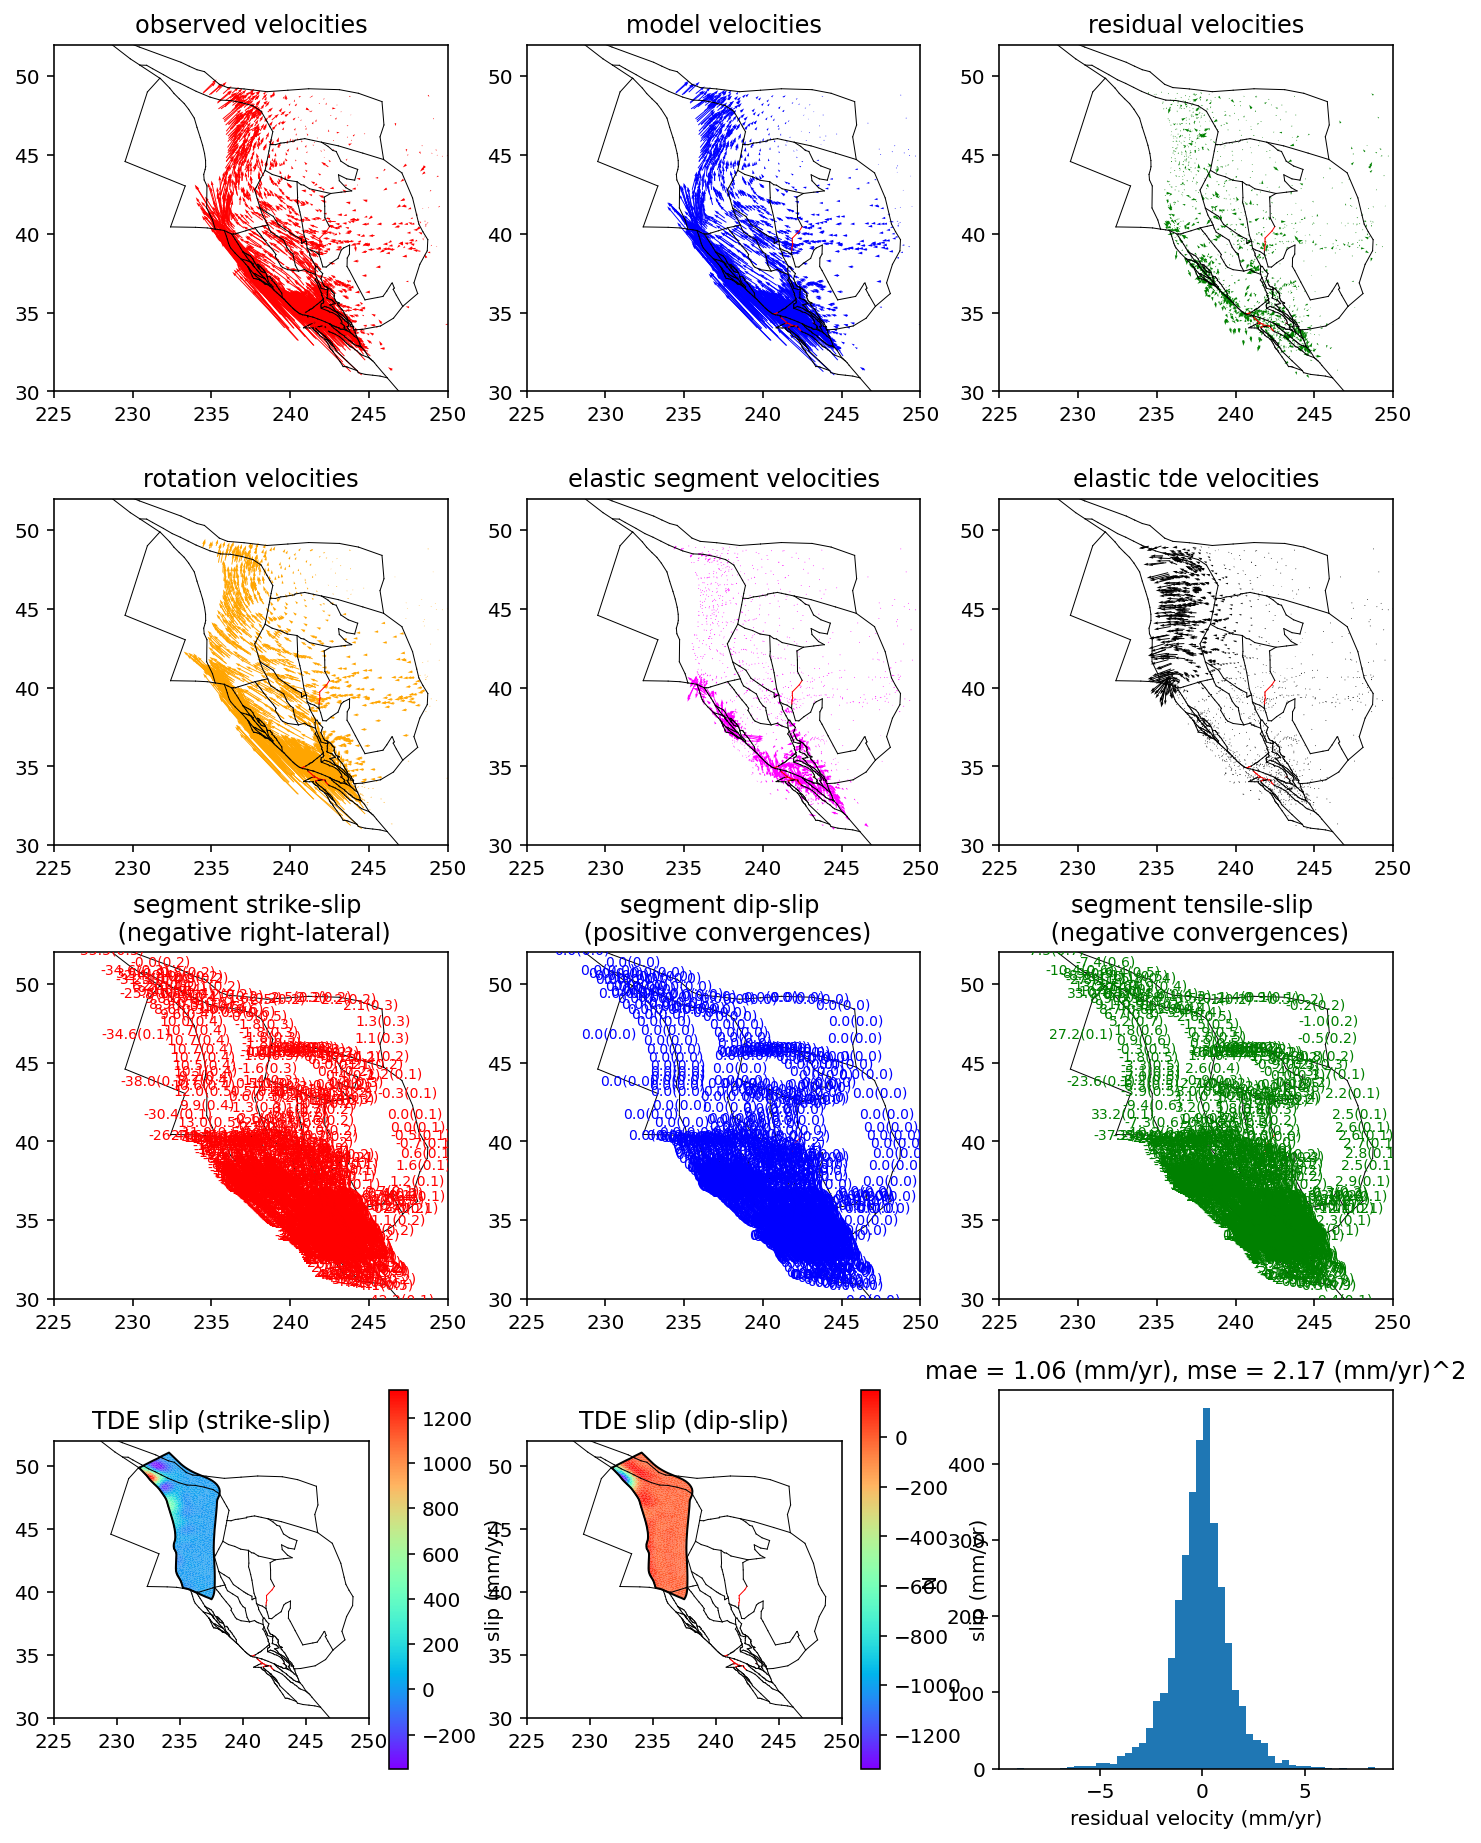

2024-06-27 13:02:52.942 | SUCCESS  | celeri.celeri:plot_estimation_summary:4996 - Wrote figures../runs/2024-06-27-13-02-27/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [12]:
# Solve the linear system
estimation_eigen = addict.Dict()

tic()
estimation_eigen.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen.state_vector = (
    estimation_eigen.state_covariance_matrix
    @ operator_eigen.T
    * weighting_vector_eigen
    @ data_vector_eigen
)
toc()

forward_data_vector_eigen = operator_eigen @ estimation_eigen.state_vector
estimation_eigen.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen, operators, station, index)

celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# 4. CVXOPT solve of dense KL (unbounded)

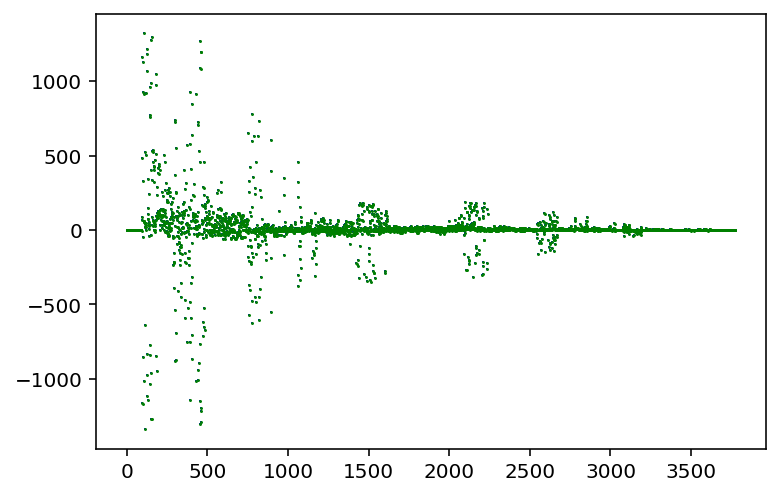

In [13]:
# Unbounded
ret = celeri.lsqlin_qp(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    opts,
)

estimation_eigen_cvxopt_unbounded = addict.Dict()
estimation_eigen_cvxopt_unbounded.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_cvxopt_unbounded.state_vector = np.array(ret["x"]).flatten()
forward_data_vector_eigen = (
    operator_eigen @ estimation_eigen_cvxopt_unbounded.state_vector
)
estimation_eigen_cvxopt_unbounded.operator = operator_eigen
post_process_estimation_eigen(
    estimation_eigen_cvxopt_unbounded, operators, station, index
)

plt.plot(estimation_eigen.pseudo_tde_state_vector, "b+", markersize=MARKERSIZE)
plt.plot(
    estimation_eigen_cvxopt_unbounded.pseudo_tde_state_vector,
    "g.",
    markersize=MARKERSIZE,
)
plt.show()

# 5. CVXOPT solve of dense KL (bounded)

In [14]:
# Basic inequality constraints for bounded
K = np.zeros(
    (eigenvectors_two_component.shape[0], estimation_eigen.state_vector.shape[0])
)
K[:, 3 * n_blocks :] = eigenvectors_two_component

A = np.zeros(
    (2 * eigenvectors_two_component.shape[0], estimation_eigen.state_vector.shape[0])
)
A[0 : eigenvectors_two_component.shape[0], 3 * n_blocks :] = -eigenvectors_two_component
A[eigenvectors_two_component.shape[0] :, 3 * n_blocks :] = eigenvectors_two_component

b = np.zeros(2 * eigenvectors_two_component.shape[0])
b[0 : eigenvectors_two_component.shape[0]] = -lower_bound_tde_only
b[eigenvectors_two_component.shape[0] :] = upper_bound_tde_only

tic()
ret = celeri.lsqlin_qp(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    A,  # A=None, inequality operator
    b,  # b=None, inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)
toc()

# Make a pseudostate vector for the eigenvalue case (just for comparision)
# ret_state_vector = np.array(ret["x"]).flatten()

estimation_eigen_cvxopt_bounded = addict.Dict()
estimation_eigen_cvxopt_bounded.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_cvxopt_bounded.state_vector = np.array(ret["x"]).flatten()
forward_data_vector_eigen = (
    operator_eigen @ estimation_eigen_cvxopt_bounded.state_vector
)
estimation_eigen_cvxopt_bounded.operator = operator_eigen
post_process_estimation_eigen(
    estimation_eigen_cvxopt_bounded, operators, station, index
)

     pcost       dcost       gap    pres   dres
 0: -3.4991e+08 -3.5120e+08  2e+06  2e-01  8e-17
 1: -3.4991e+08 -3.5015e+08  2e+05  2e-02  2e-21
 2: -3.4992e+08 -3.5010e+08  2e+05  1e-02  3e-21
 3: -3.4992e+08 -3.5005e+08  1e+05  5e-03  2e-21
 4: -3.4992e+08 -3.4998e+08  6e+04  1e-03  2e-21
 5: -3.4992e+08 -3.4994e+08  3e+04  4e-04  4e-21
 6: -3.4992e+08 -3.4993e+08  1e+04  1e-04  3e-21
 7: -3.4992e+08 -3.4992e+08  3e+03  3e-05  3e-21
 8: -3.4992e+08 -3.4992e+08  3e+03  2e-05  2e-21
 9: -3.4992e+08 -3.4992e+08  1e+03  7e-06  5e-21
10: -3.4992e+08 -3.4992e+08  7e+02  2e-06  2e-21
11: -3.4992e+08 -3.4992e+08  3e+02  8e-07  2e-21
12: -3.4992e+08 -3.4992e+08  2e+02  2e-07  3e-21
13: -3.4992e+08 -3.4992e+08  7e+01  7e-08  4e-21
Optimal solution found.
Elapsed time: 0.209282 seconds.



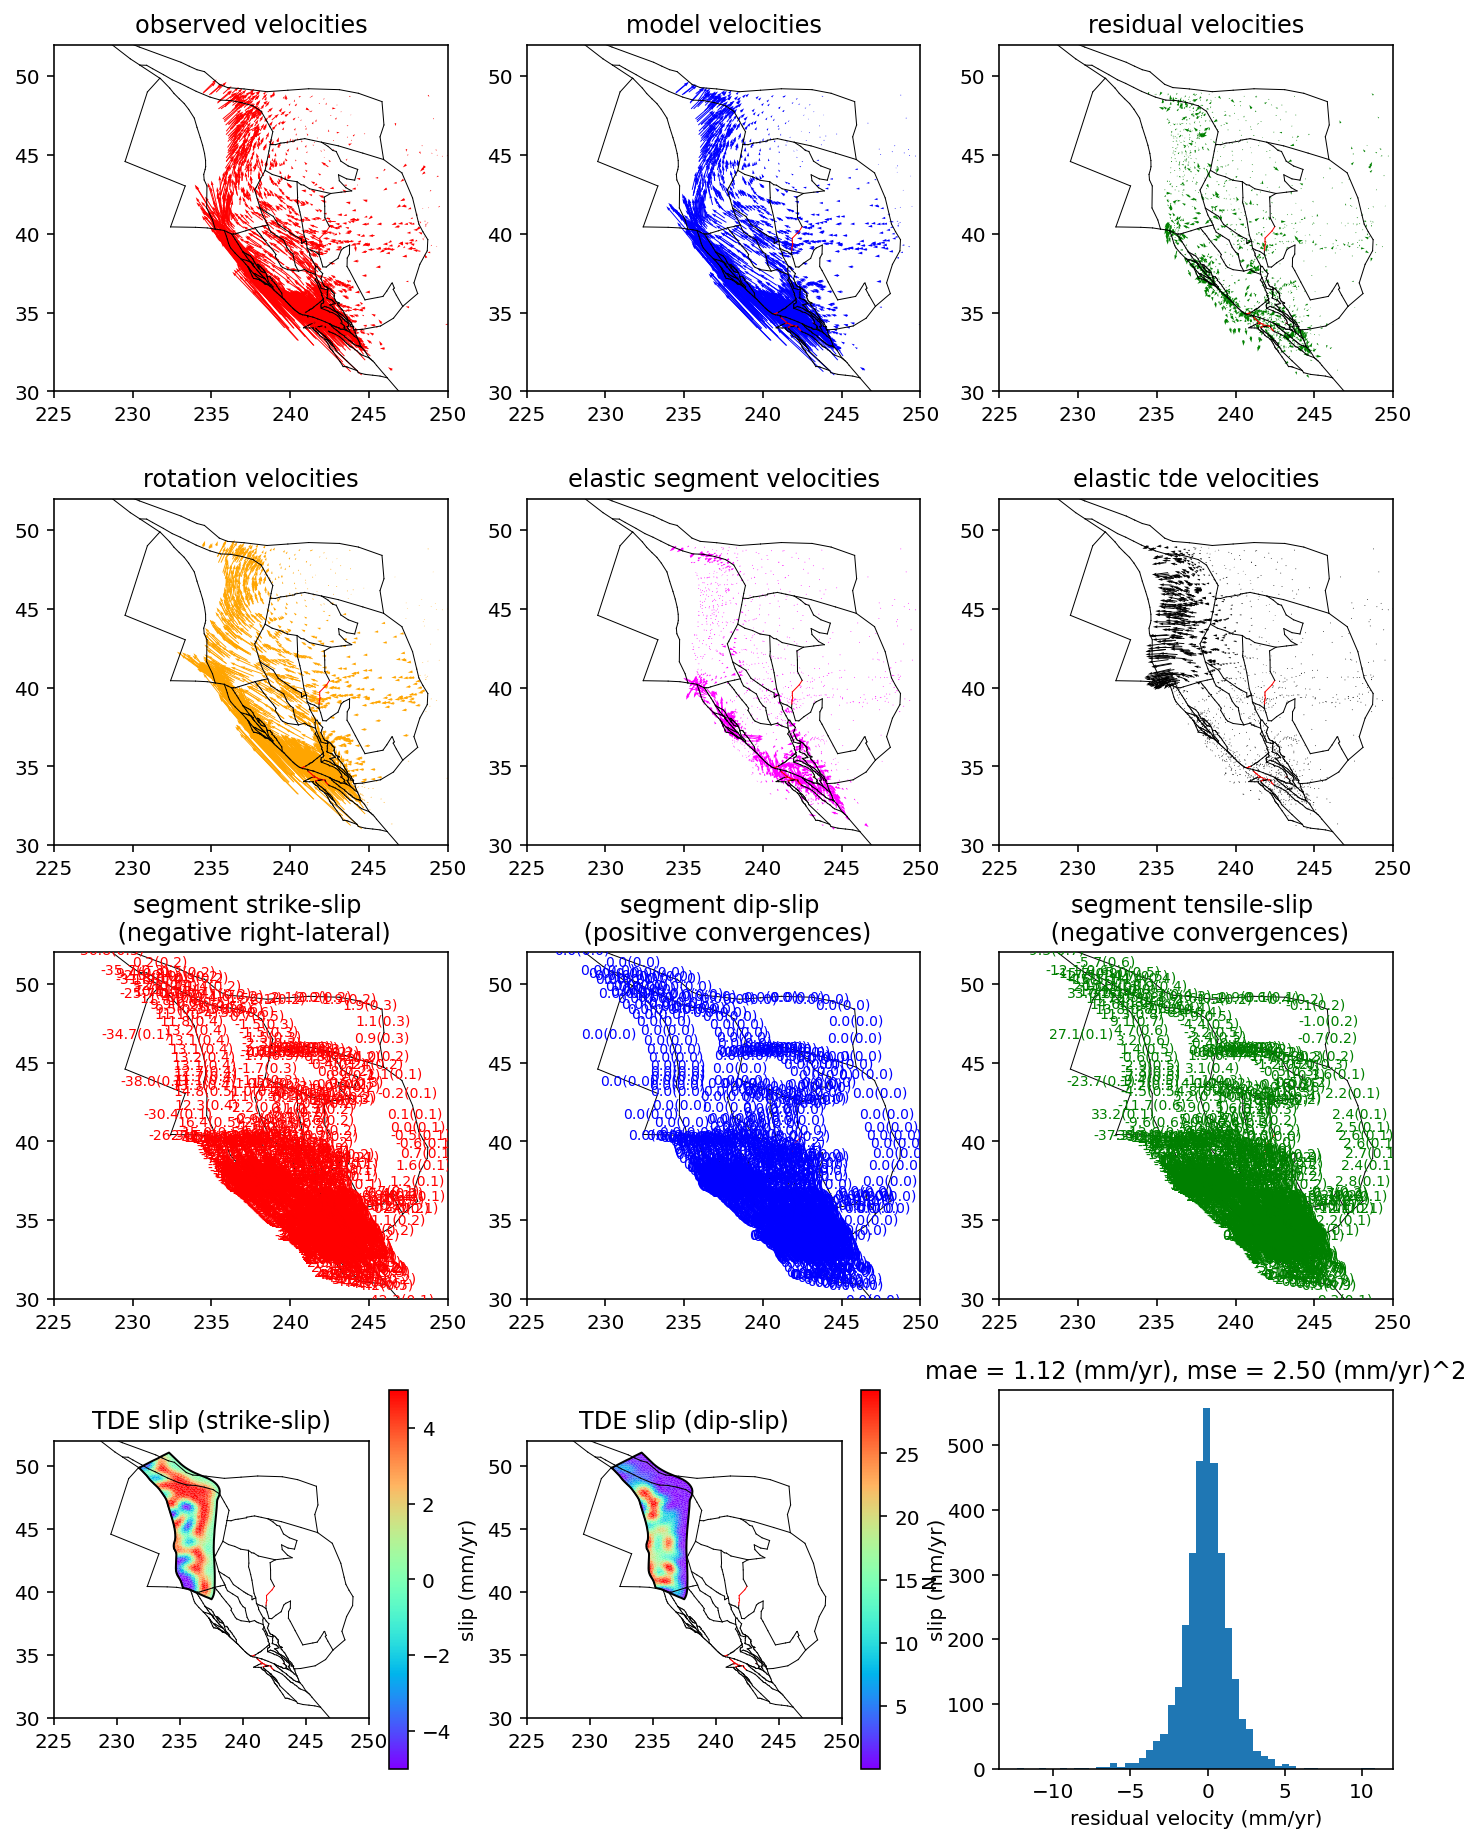

2024-06-27 13:03:00.735 | SUCCESS  | celeri.celeri:plot_estimation_summary:4996 - Wrote figures../runs/2024-06-27-13-02-27/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [15]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen_cvxopt_bounded,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Comparision of estimated state vectors

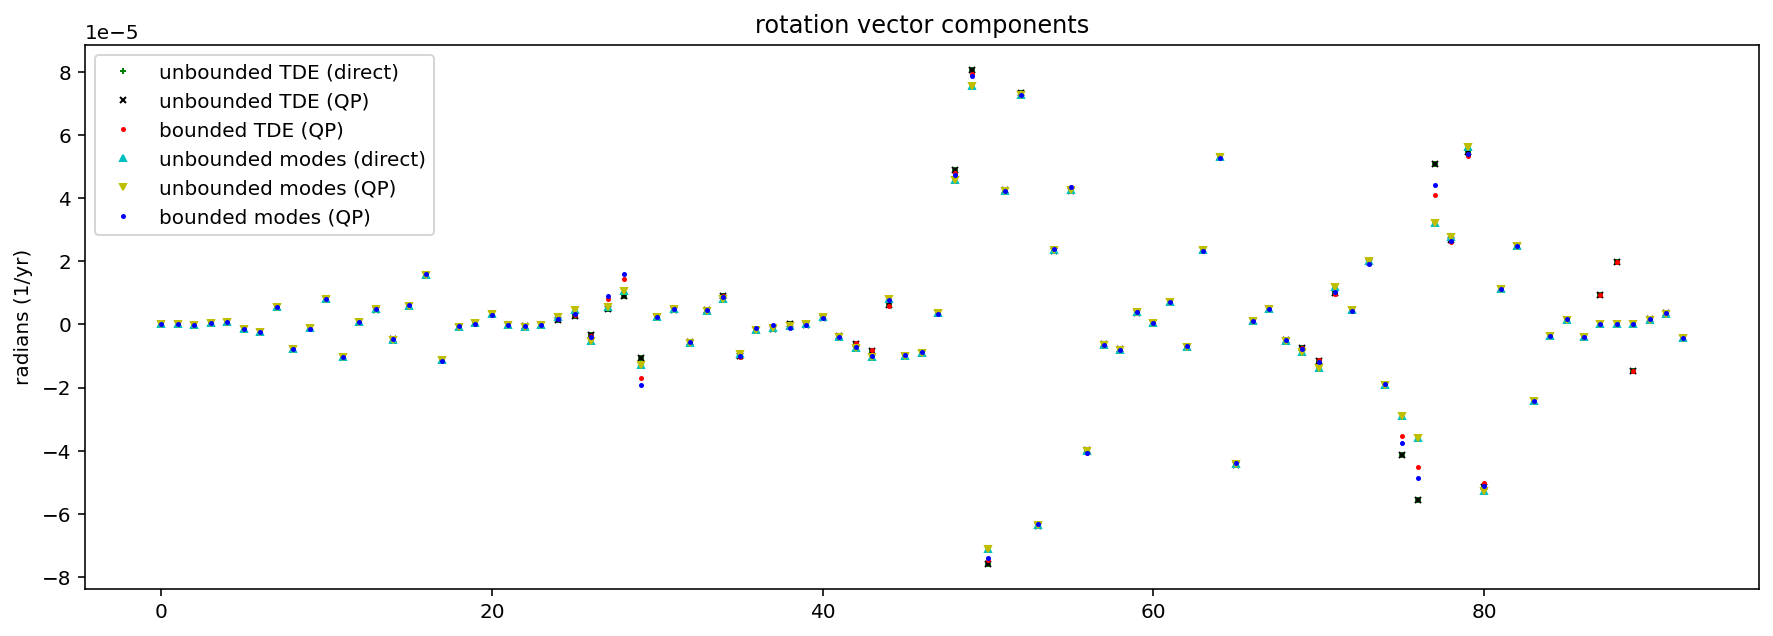

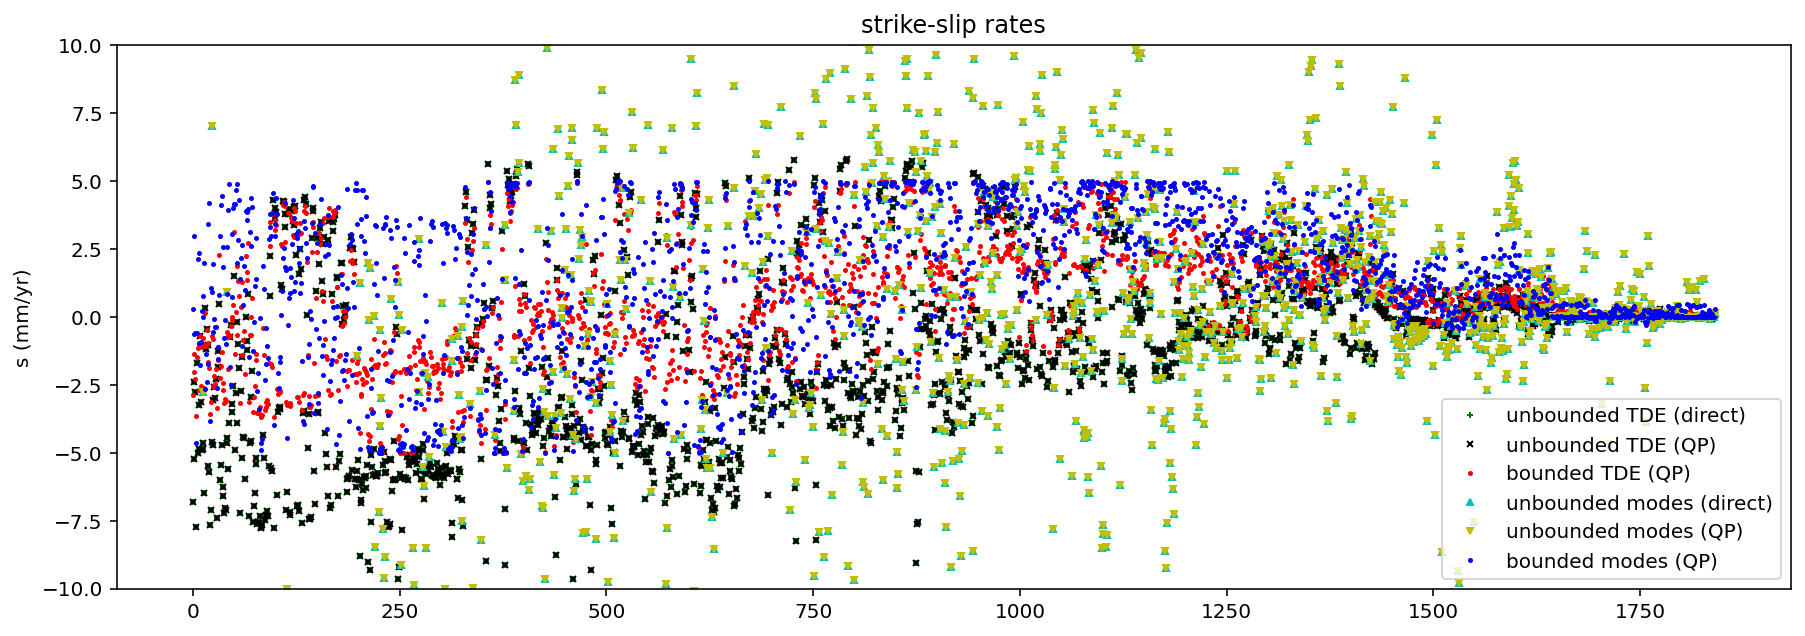

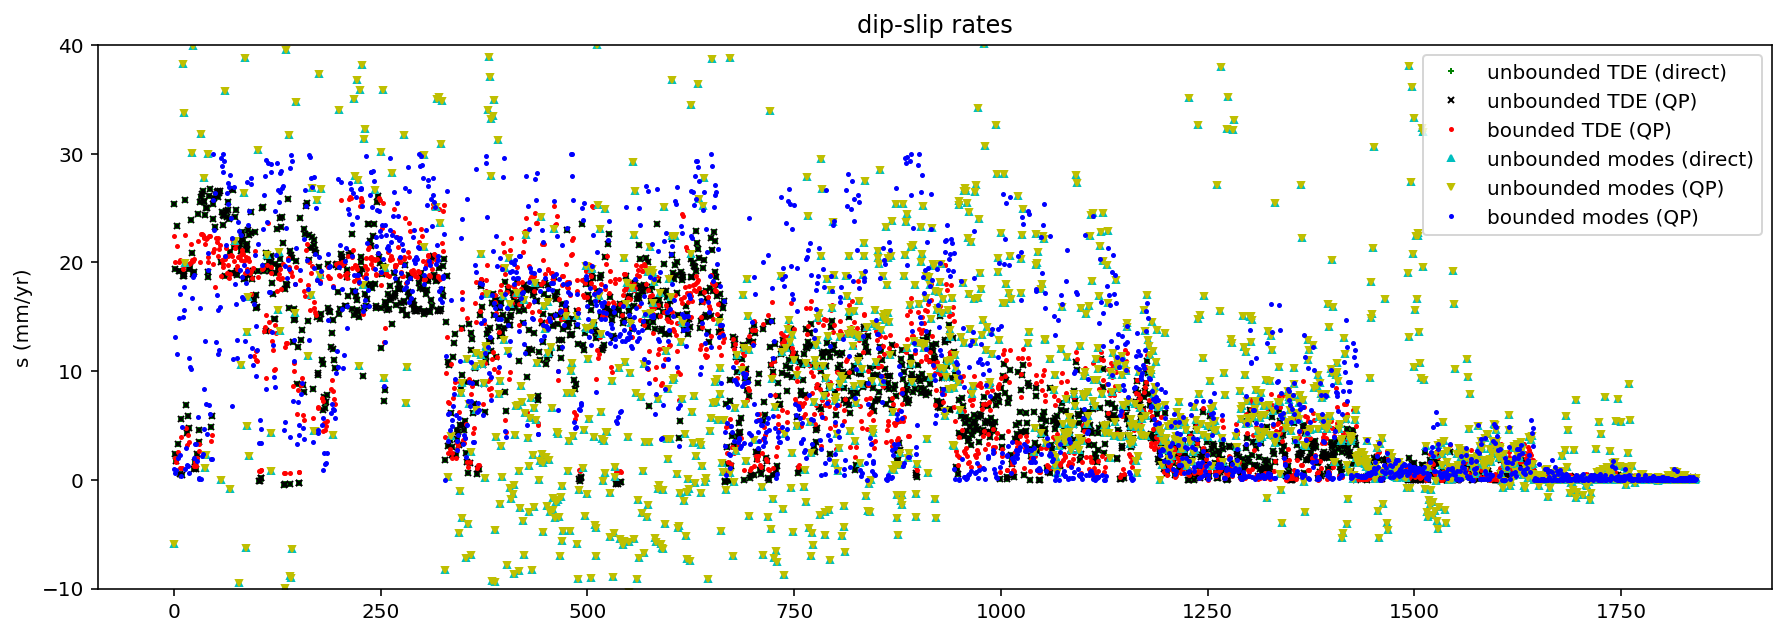

In [35]:
# Block motion parameters
MARKERSIZE = 3
plt.figure(figsize=(15, 5))
plt.plot(
    estimation.state_vector[0 : 3 * index.n_blocks],
    "+g",
    label="unbounded TDE (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_unbounded.state_vector[0 : 3 * index.n_blocks],
    "xk",
    label="unbounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_bounded.state_vector[0 : 3 * index.n_blocks],
    "r.",
    label="bounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen.pseudo_tde_state_vector[0 : 3 * index.n_blocks],
    "^c",
    label="unbounded modes (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_unbounded.pseudo_tde_state_vector[0 : 3 * index.n_blocks],
    "vy",
    label="unbounded modes (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_bounded.pseudo_tde_state_vector[0 : 3 * index.n_blocks],
    "b.",
    label="bounded modes (QP)",
    markersize=MARKERSIZE,
)
# plt.ylim([-10, 40])
plt.legend()
plt.ylabel("radians (1/yr)")
plt.title("rotation vector components")
plt.show()


# Strike-slip rates
plt.figure(figsize=(15, 5))
plt.plot(
    estimation.state_vector[3 * index.n_blocks :: 2],
    "+g",
    label="unbounded TDE (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_unbounded.state_vector[3 * index.n_blocks :: 2],
    "xk",
    label="unbounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_bounded.state_vector[3 * index.n_blocks :: 2],
    "r.",
    label="bounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks :: 2],
    "^c",
    label="unbounded modes (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_unbounded.pseudo_tde_state_vector[3 * index.n_blocks :: 2],
    "vy",
    label="unbounded modes (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_bounded.pseudo_tde_state_vector[3 * index.n_blocks :: 2],
    "b.",
    label="bounded modes (QP)",
    markersize=MARKERSIZE,
)
plt.ylim([-10, 10])
plt.legend()
plt.ylabel("s (mm/yr)")
plt.title("strike-slip rates")
plt.show()


# Dip-slip rates
plt.figure(figsize=(15, 5))
plt.plot(
    estimation.state_vector[3 * index.n_blocks + 1 :: 2],
    "+g",
    label="unbounded TDE (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_unbounded.state_vector[3 * index.n_blocks + 1 :: 2],
    "xk",
    label="unbounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_bounded.state_vector[3 * index.n_blocks + 1 :: 2],
    "r.",
    label="bounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks + 1 :: 2],
    "^c",
    label="unbounded modes (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_unbounded.pseudo_tde_state_vector[
        3 * index.n_blocks + 1 :: 2
    ],
    "vy",
    label="unbounded modes (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_bounded.pseudo_tde_state_vector[
        3 * index.n_blocks + 1 :: 2
    ],
    "b.",
    label="bounded modes (QP)",
    markersize=MARKERSIZE,
)
plt.ylim([-10, 40])
plt.legend()
plt.ylabel("s (mm/yr)")
plt.title("dip-slip rates")
plt.show()

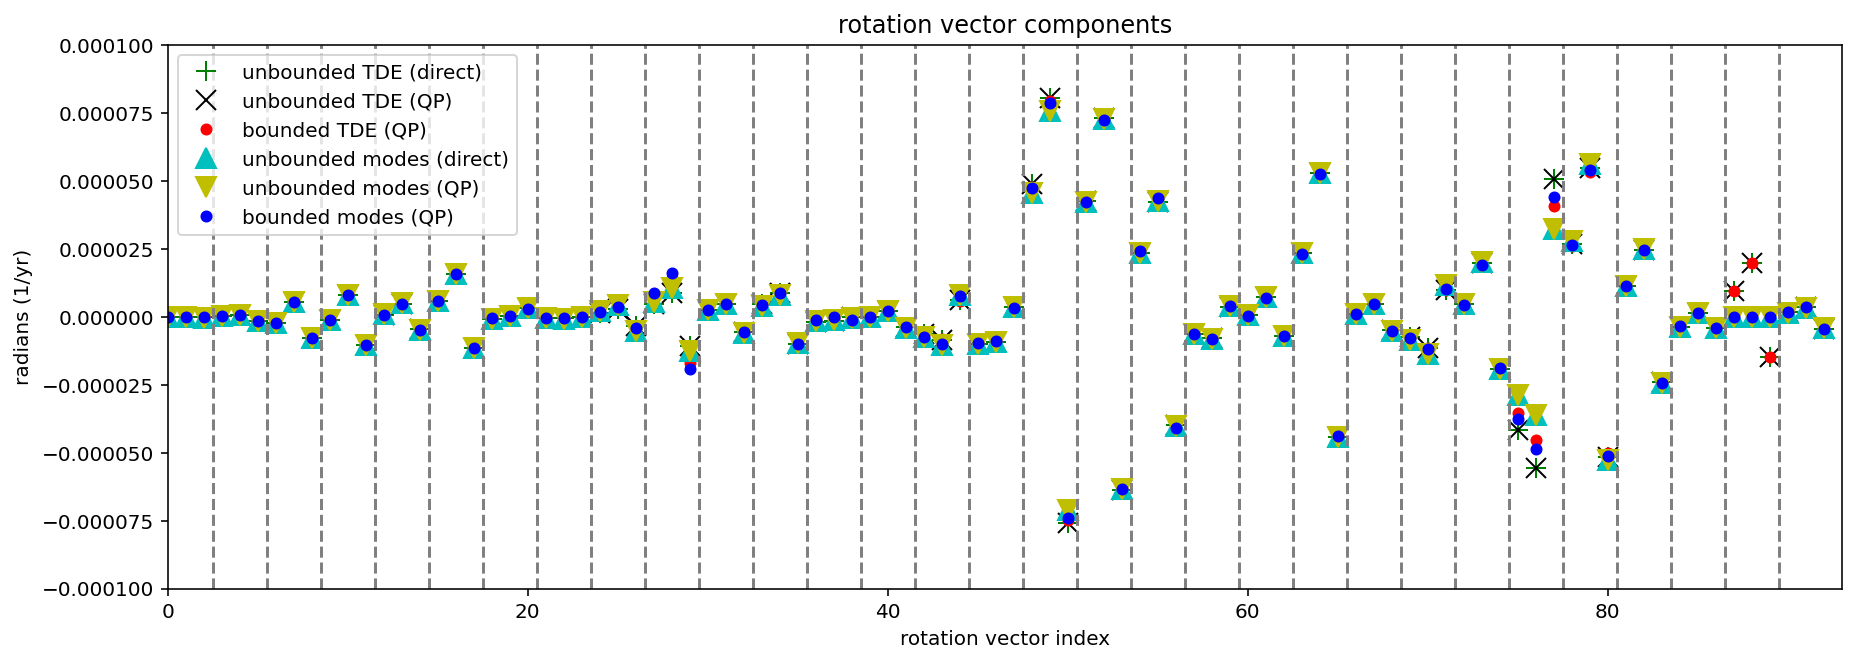

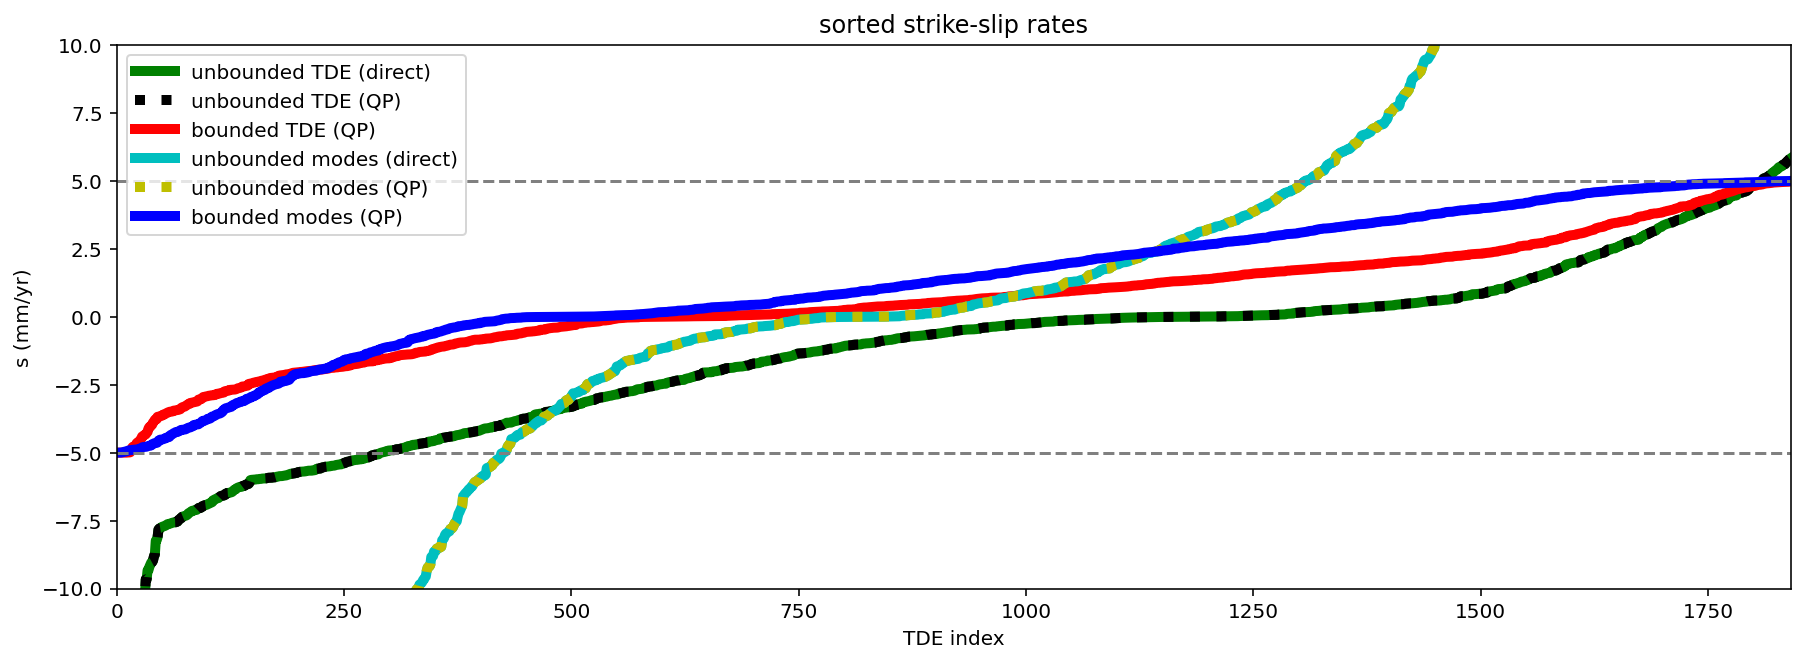

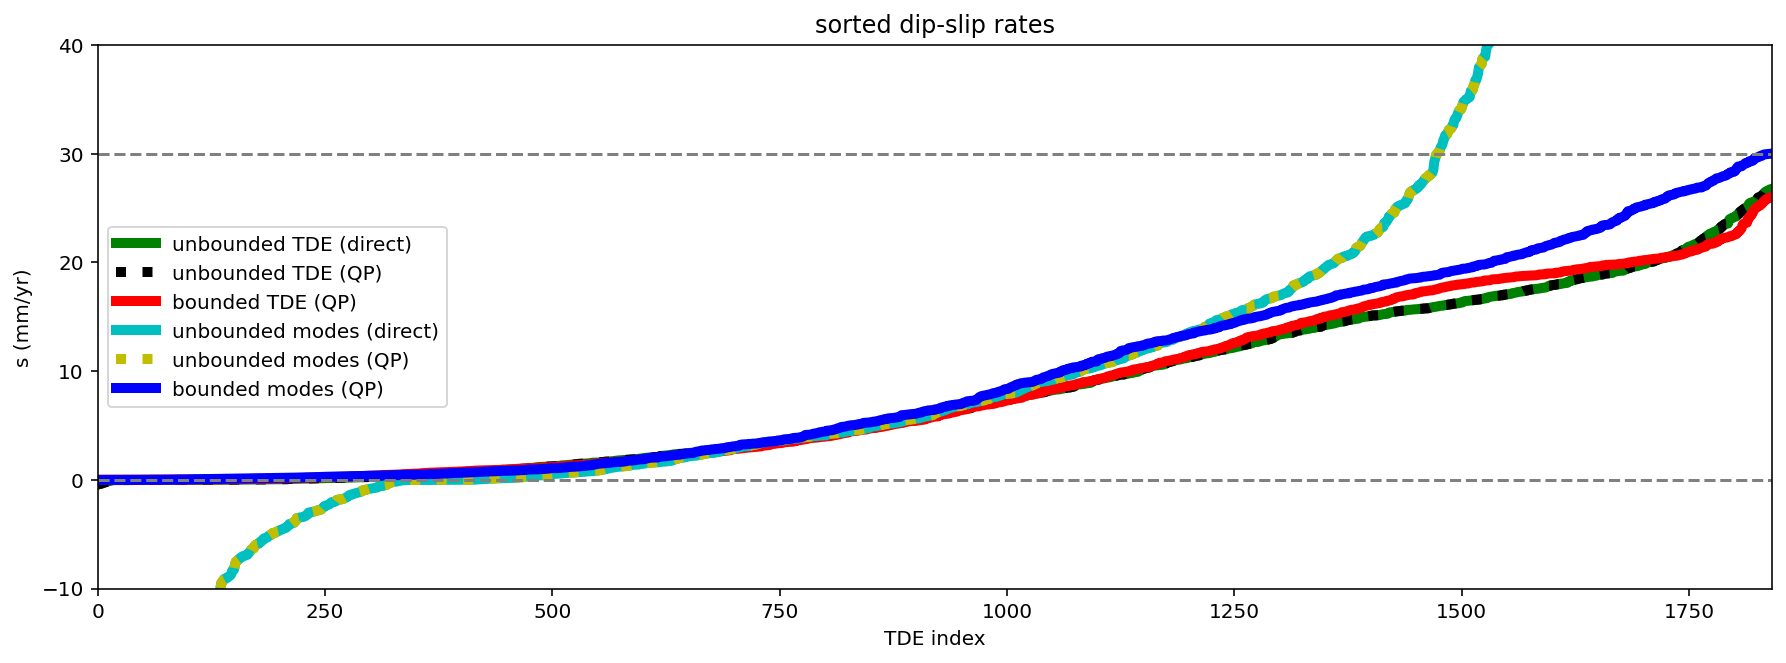

In [72]:
# Block motion parameters
MARKERSIZE = 10.0
LINEWIDTH = 5.0
plt.figure(figsize=(15, 5))
plt.plot(
    estimation.state_vector[0 : 3 * index.n_blocks],
    "+g",
    label="unbounded TDE (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_unbounded.state_vector[0 : 3 * index.n_blocks],
    "xk",
    label="unbounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_cvxopt_bounded.state_vector[0 : 3 * index.n_blocks],
    "r.",
    label="bounded TDE (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen.pseudo_tde_state_vector[0 : 3 * index.n_blocks],
    "^c",
    label="unbounded modes (direct)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_unbounded.pseudo_tde_state_vector[0 : 3 * index.n_blocks],
    "vy",
    label="unbounded modes (QP)",
    markersize=MARKERSIZE,
)
plt.plot(
    estimation_eigen_cvxopt_bounded.pseudo_tde_state_vector[0 : 3 * index.n_blocks],
    "b.",
    label="bounded modes (QP)",
    markersize=MARKERSIZE,
)

for i in range(len(block)):
    plt.axvline(x=3 * i - 0.5, color="gray", linestyle="--")


plt.xlim([0, 3 * len(block)])
plt.ylim([-1e-4, 1e-4])
plt.legend()
plt.xlabel("rotation vector index")
plt.ylabel("radians (1/yr)")
plt.title("rotation vector components")
plt.show()


# Strike-slip rates
plt.figure(figsize=(15, 5))
plt.plot(
    np.sort(estimation.state_vector[3 * index.n_blocks :: 2]),
    "-g",
    label="unbounded TDE (direct)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(estimation_cvxopt_unbounded.state_vector[3 * index.n_blocks :: 2]),
    ":k",
    label="unbounded TDE (QP)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(estimation_cvxopt_bounded.state_vector[3 * index.n_blocks :: 2]),
    "r-",
    label="bounded TDE (QP)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks :: 2]),
    "-c",
    label="unbounded modes (direct)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(
        estimation_eigen_cvxopt_unbounded.pseudo_tde_state_vector[
            3 * index.n_blocks :: 2
        ]
    ),
    ":y",
    label="unbounded modes (QP)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(
        estimation_eigen_cvxopt_bounded.pseudo_tde_state_vector[3 * index.n_blocks :: 2]
    ),
    "-b",
    label="bounded modes (QP)",
    linewidth=LINEWIDTH,
)
plt.axhline(y=-5.0, color="gray", linestyle="--")
plt.axhline(y=5.0, color="gray", linestyle="--")
plt.xlim([0, index.n_tde[0]])
plt.ylim([-10, 10])
plt.legend()
plt.xlabel("TDE index")
plt.ylabel("s (mm/yr)")
plt.title("sorted strike-slip rates")
plt.show()

# Dip-slip rates
plt.figure(figsize=(15, 5))
plt.plot(
    np.sort(estimation.state_vector[3 * index.n_blocks + 1 :: 2]),
    "-g",
    label="unbounded TDE (direct)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(estimation_cvxopt_unbounded.state_vector[3 * index.n_blocks + 1 :: 2]),
    ":k",
    label="unbounded TDE (QP)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(estimation_cvxopt_bounded.state_vector[3 * index.n_blocks + 1 :: 2]),
    "r-",
    label="bounded TDE (QP)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(estimation_eigen.pseudo_tde_state_vector[3 * index.n_blocks + 1 :: 2]),
    "-c",
    label="unbounded modes (direct)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(
        estimation_eigen_cvxopt_unbounded.pseudo_tde_state_vector[
            3 * index.n_blocks + 1 :: 2
        ]
    ),
    ":y",
    label="unbounded modes (QP)",
    linewidth=LINEWIDTH,
)
plt.plot(
    np.sort(
        estimation_eigen_cvxopt_bounded.pseudo_tde_state_vector[
            3 * index.n_blocks + 1 :: 2
        ]
    ),
    "-b",
    label="bounded modes (QP)",
    linewidth=LINEWIDTH,
)

plt.axhline(y=0.0, color="gray", linestyle="--")
plt.axhline(y=30.0, color="gray", linestyle="--")
plt.xlim([0, index.n_tde[0]])
plt.ylim([-10, 40])
plt.legend()
plt.xlabel("TDE index")
plt.ylabel("s (mm/yr)")
plt.title("sorted dip-slip rates")
plt.show()

In [17]:
# A = np.zeros((2 * eigenvectors_two_component.shape[0], ret_state_vector.shape[0]))
# A[0 : eigenvectors_two_component.shape[0], 3 * n_blocks :] = -eigenvectors_two_component
# A[eigenvectors_two_component.shape[0] :, 3 * n_blocks :] = eigenvectors_two_component

# b = np.zeros(2 * eigenvectors_two_component.shape[0])
# b[0 : eigenvectors_two_component.shape[0]] = -lower_bound_tde_only
# b[eigenvectors_two_component.shape[0] :] = upper_bound_tde_only

# print(A.shape, b.shape)

# Add sign constraint on one slip rate

In [18]:
A = np.zeros((2 * eigenvectors_two_component.shape[0], ret_state_vector.shape[0]))
A[0 : eigenvectors_two_component.shape[0], 3 * n_blocks :] = -eigenvectors_two_component
A[eigenvectors_two_component.shape[0] :, 3 * n_blocks :] = eigenvectors_two_component

b = np.zeros(2 * eigenvectors_two_component.shape[0])
b[0 : eigenvectors_two_component.shape[0]] = -lower_bound_tde_only
b[eigenvectors_two_component.shape[0] :] = upper_bound_tde_only

print(A.shape, b.shape)


AA = np.zeros((1, ret_state_vector.shape[0]))
AA[0, 0 : 3 * n_blocks] = operators.slip_rate_constraints

bb = np.zeros(1)

print(AA.shape, bb.shape)


AAA = np.vstack((A, AA))
bbb = np.hstack((b, bb))
print(AAA.shape, bbb.shape)

NameError: name 'ret_state_vector' is not defined

     pcost       dcost       gap    pres   dres
 0: -3.4991e+08 -3.5120e+08  2e+06  2e-01  1e-08
 1: -3.4991e+08 -3.5015e+08  2e+05  2e-02  9e-10
 2: -3.4992e+08 -3.5010e+08  2e+05  1e-02  5e-10
 3: -3.4992e+08 -3.5005e+08  1e+05  5e-03  2e-10
 4: -3.4992e+08 -3.4998e+08  6e+04  1e-03  6e-11
 5: -3.4992e+08 -3.4994e+08  3e+04  4e-04  2e-11
 6: -3.4992e+08 -3.4993e+08  1e+04  1e-04  6e-12
 7: -3.4992e+08 -3.4992e+08  3e+03  3e-05  1e-12
 8: -3.4992e+08 -3.4992e+08  3e+03  2e-05  1e-12
 9: -3.4992e+08 -3.4992e+08  1e+03  7e-06  3e-13
10: -3.4992e+08 -3.4992e+08  7e+02  2e-06  1e-13
11: -3.4992e+08 -3.4992e+08  3e+02  8e-07  4e-14
12: -3.4992e+08 -3.4992e+08  2e+02  2e-07  1e-14
13: -3.4992e+08 -3.4992e+08  7e+01  7e-08  3e-15
Optimal solution found.


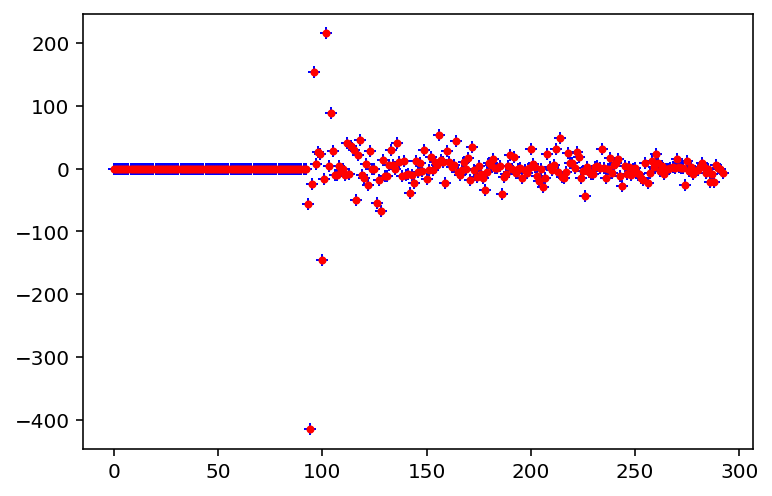

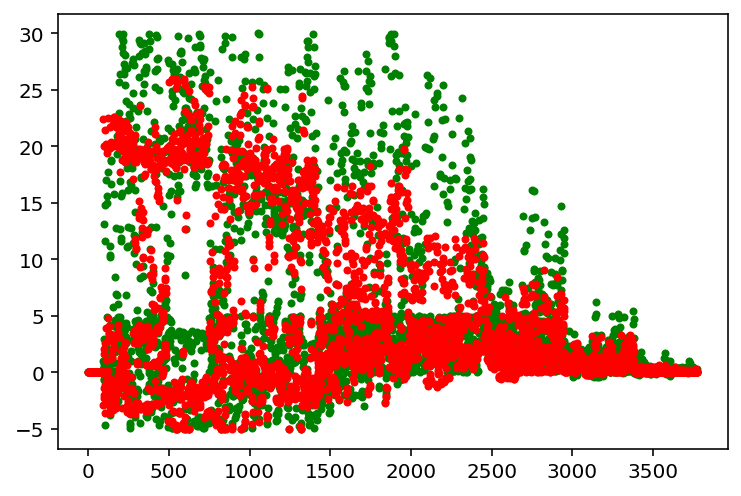

In [ ]:
ret = celeri.lsqlin_qp(
    operator_eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    AAA,  # A=None, inequality operator
    bbb,  # b=None, inequality vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Make a pseudostate vector for the eigenvalue case (just for comparision)
ret_state_vector = np.array(ret["x"]).flatten()

estimation_eigen_ret = addict.Dict()
estimation_eigen_ret.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen_ret.state_vector = ret_state_vector
forward_data_vector_eigen = operator_eigen @ estimation_eigen_ret.state_vector
estimation_eigen_ret.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen_ret, operators, station, index)


ret_pseudo_state_vector = np.zeros_like(estimation.state_vector)
ret_pseudo_state_vector[0 : 3 * index.n_blocks] = estimation_eigen_ret.state_vector[
    0 : 3 * index.n_blocks
]
ret_pseudo_state_vector[3 * index.n_blocks : :] = estimation_eigen_ret.tde_rates

plt.plot(estimation_eigen.state_vector, "b+")
plt.plot(np.array(ret["x"]).flatten(), "r.")
plt.show()

# plt.plot(estimation_eigen.pseudo_state_vector, "b+")
plt.plot(ret_pseudo_state_vector, "g.")
plt.plot(np.array(ret_bounded["x"]).flatten(), "r.")

plt.show()

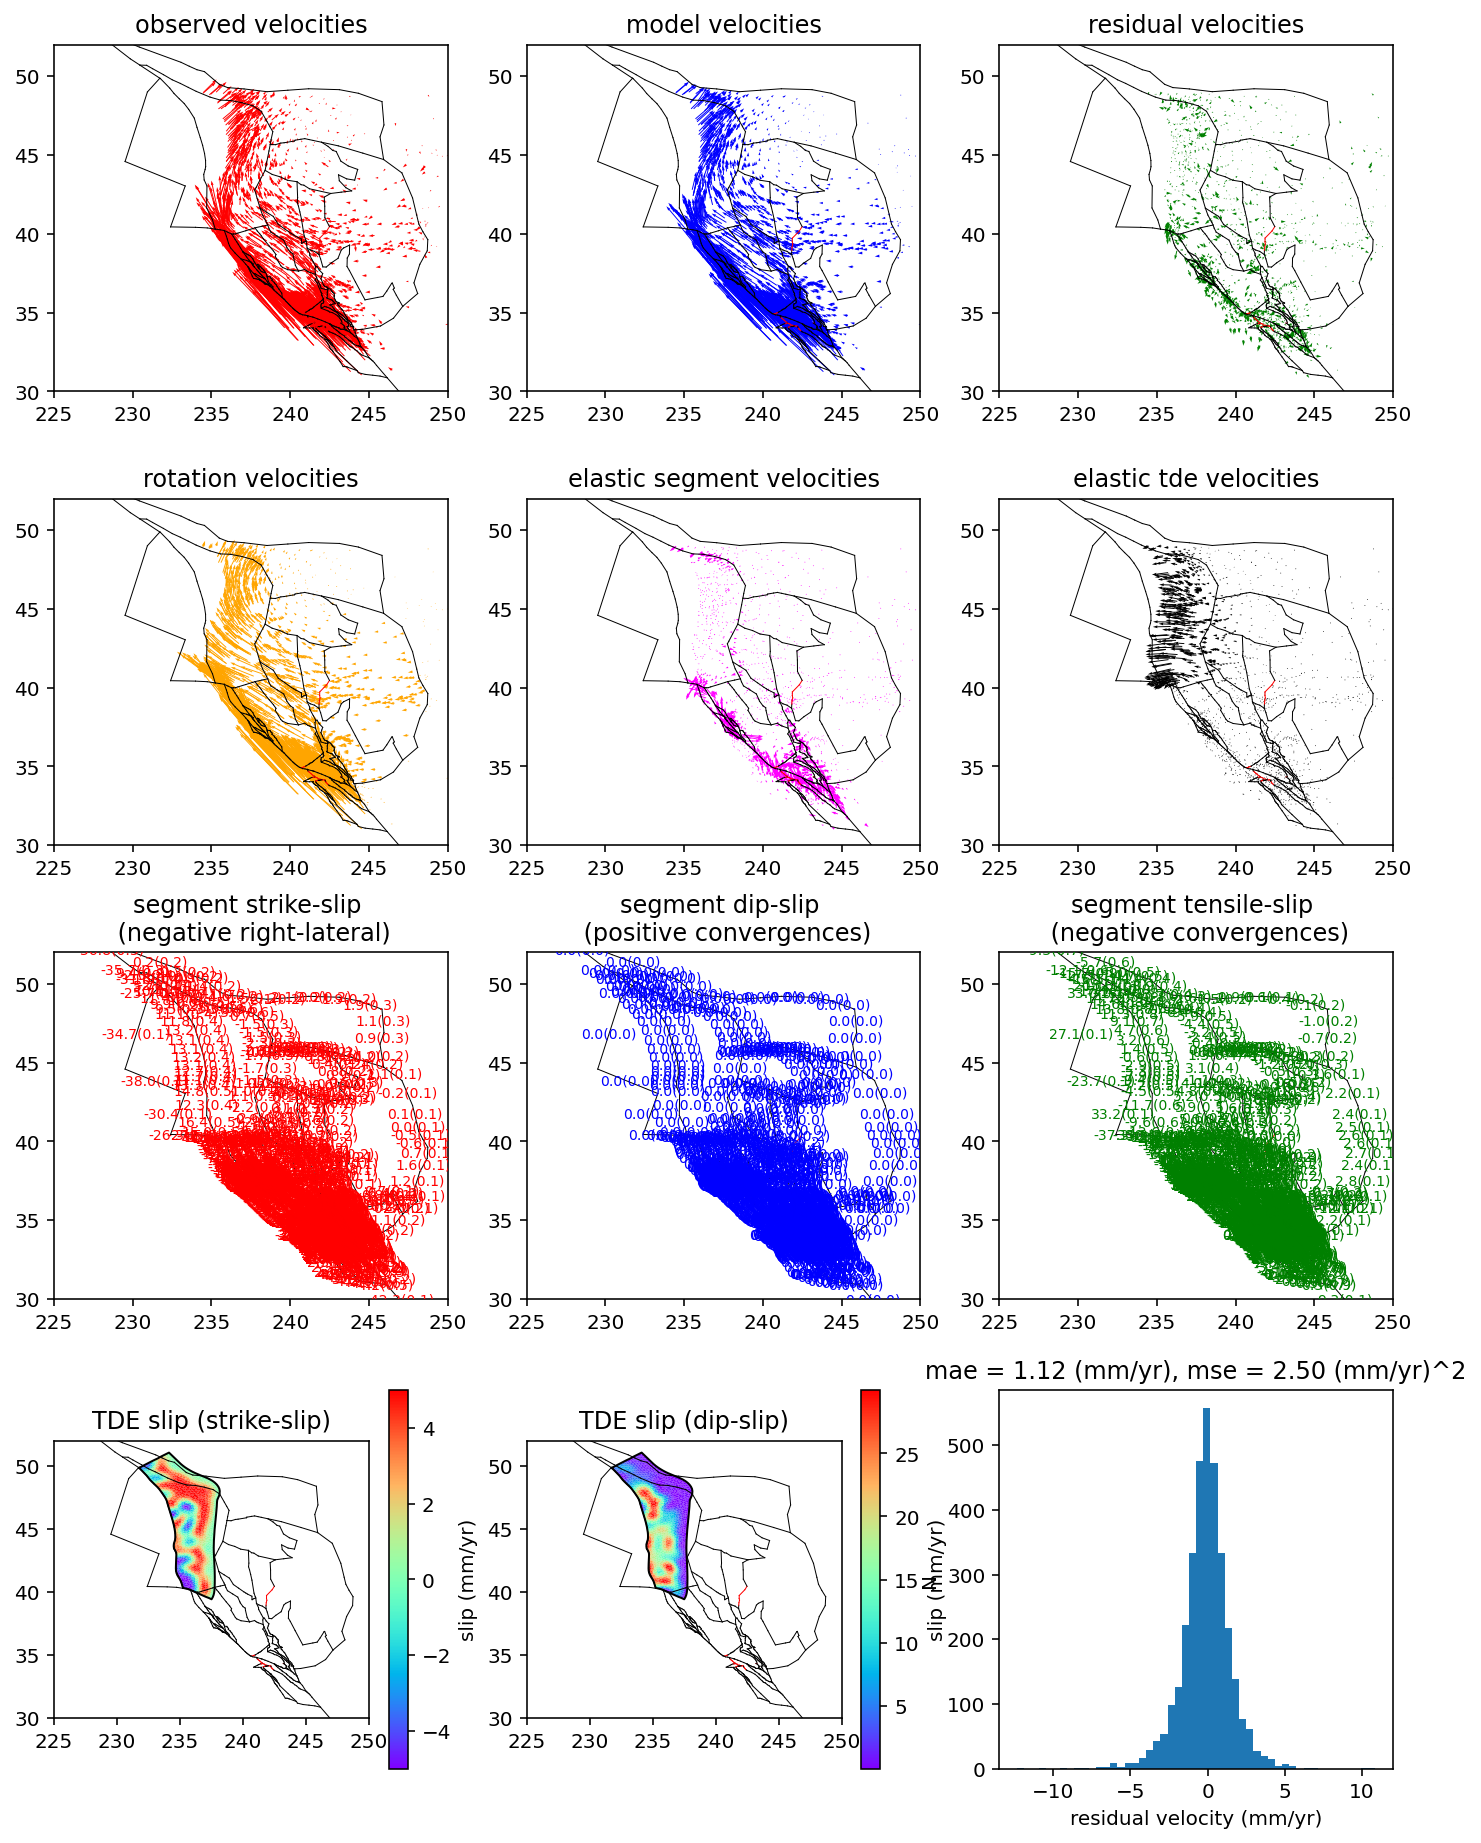

2024-06-27 11:13:57.407 | SUCCESS  | celeri.celeri:plot_estimation_summary:4996 - Wrote figures../runs/2024-06-27-11-13-15/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [ ]:
estimation_eigen.operator = operator_eigen
estimation_eigen.state_vector = ret_state_vector
post_process_estimation_eigen(estimation_eigen, operators, station, index)
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

array([3372, 3373, 3374])

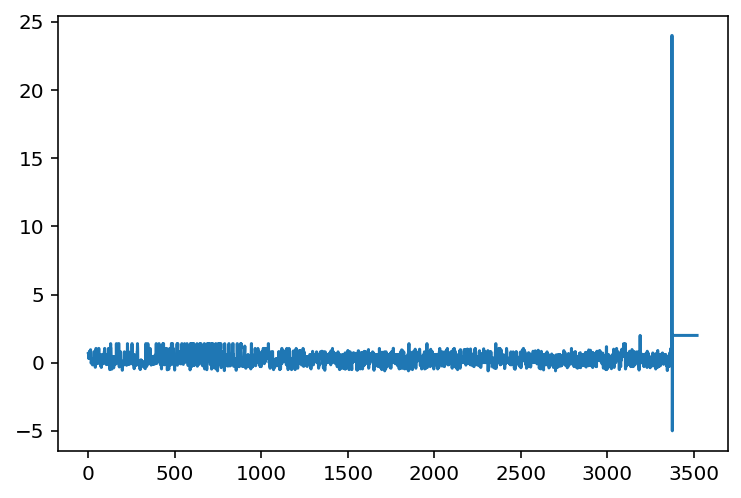

In [ ]:
plt.plot(np.log10(weighting_vector_eigen))
np.where(weighting_vector_eigen == np.max(weighting_vector_eigen))[0]

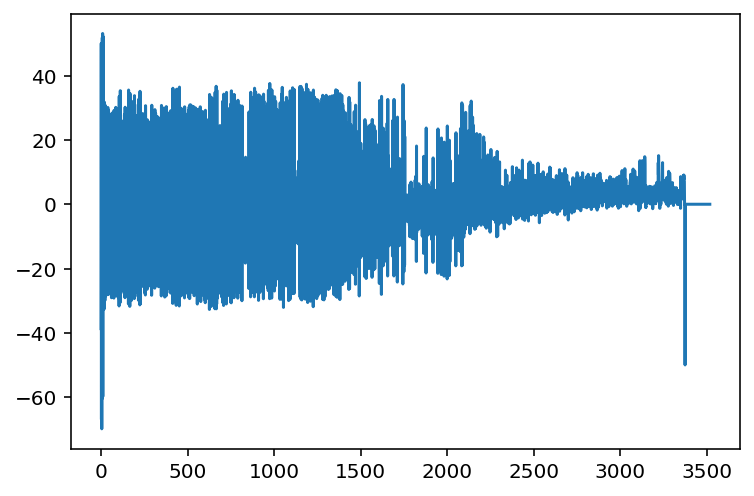

In [ ]:
plt.plot(data_vector_eigen)

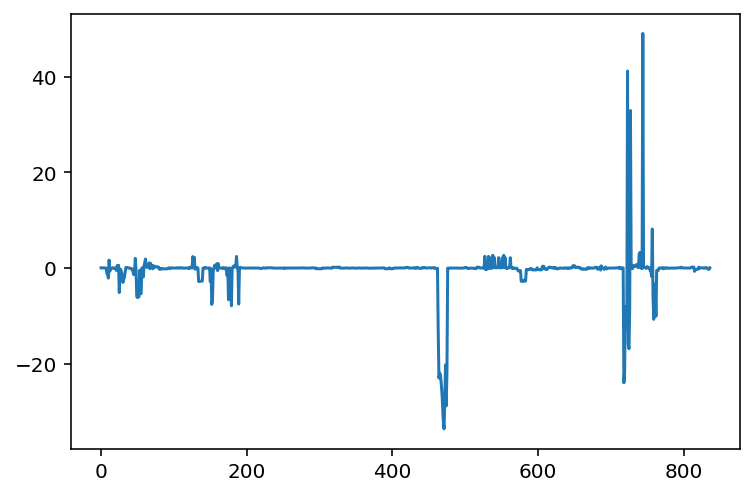

In [ ]:
plt.plot(estimation.strike_slip_rates - estimation_eigen.strike_slip_rates)